# RRAM Relaxation Data Notebook

This notebook contains the analysis on empirical RRAM relaxation data across three technologies (A, B, C). It loads and processes the measurements taken for each technology.

In [1]:
# Imports
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
import scipy.stats
# from matplotlib.offsetbox import AnchoredText

%config InlineBackend.figure_format = 'svg'

## Load the technology and its settings

Below, choose which technology to load data and settings for:

In [2]:
# Choose technology here
TECH = 'C'

# Load settings for technology
with open(f"data/tech{TECH}/settings.json") as sfile:
    settings = json.load(sfile)

## Time series analysis
In this section, we will look at example time series data on a log scale and also examine the power spectral density (PSD). First, let us load the time series data:

### Example Time Series Data

Below, we can look at the time series data for the ranges chosen above:

0 step 1
0 step 2
8 step 1
8 step 2
16 step 1
16 step 2
31 step 1
31 step 2


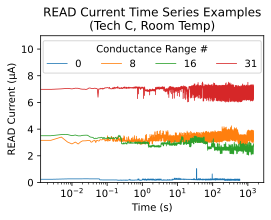

In [3]:
# Load data for technology
with gzip.open(f"data/tech{TECH}/tsdata.min.tsv.gz", "rt") as datafile:
    # Plot example time series data
    fig = plt.figure(figsize=(4,2.7))
    ax = fig.add_subplot(111)
    ax.set_title(f"READ Current Time Series Examples\n(Tech {TECH}, Room Temp)")
    for r in settings["ts_ranges"]:
        # Select data
        d = datafile.readline()
        print(r, "step 1")
        d = np.fromstring(d, dtype=float, sep='\t')[2:]
        print(r, "step 2")

        # Plot time series data
        plt.plot(np.arange(len(d))/settings["fs"], d*1e6*0.2, label=r, linewidth=0.8)

    # Format and display
    ax.legend(title="Conductance Range #", ncol=4, loc=9)
    ax.set_ylim(*[v*0.2 for v in settings["ts_ylim"]])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("READ Current (µA)")
    ax.set_xscale("log")
    plt.savefig(f"figs/tech{TECH}/time-series-i.png", dpi=300, bbox_inches="tight")
    plt.show()

### Power Spectral Density (PSD)

In this section, we will look at the PSDs to understand the relaxation behavior better:

0 step 1
0 step 2
8 step 1
8 step 2
16 step 1
16 step 2
31 step 1
31 step 2


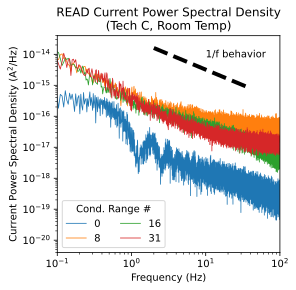

In [4]:
# Load data for technology
with gzip.open(f"data/tech{TECH}/tsdata.min.tsv.gz", "rt") as datafile:
    # Plot power spectral density (PSD)
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_title(f"READ Current Power Spectral Density\n(Tech {TECH}, Room Temp)")
    slopes = []
    for i, r in enumerate(settings["ts_ranges"]):
        # Select data
        d = datafile.readline()
        print(r, "step 1")
        d = np.fromstring(d, dtype=float, sep='\t')[2:]
        print(r, "step 2")

        # # Lomb-Scargle PSD
        # f = np.logspace(np.log10(1/600), np.log10(2), 500)
        # f = np.logspace(np.log10(2), np.log10(400/2), 1000)
        # p = scipy.signal.lombscargle(d["time"], d["g"], f)

        # Welch PSD
        f, p = scipy.signal.welch(d*0.2, fs=settings["fs"], nperseg=settings["psd_nperseg"])
        plt.plot(f, p, label=r, linewidth=0.8)

        # # Power law fit
        # a, b = np.polyfit(np.log(f[[30,-30]]), np.log(p[[30,-30]]), 1)
        # print(f"Range {r} slope: {a}")
        # slopes.append(a)
        # plt.plot(f[1:], np.exp(a*np.log(f[1:]) + b), 'k--', zorder=10, linewidth=2)

        # # 1/f fit
        # fitfn = lambda logf, A: A - logf
        # params, _ = scipy.optimize.curve_fit(fitfn, np.log(f), np.log(p))
        # A = params[0]
        # print(A)
        # plt.plot(f, np.exp(fitfn(np.log(f), A)), 'k--', zorder=10, linewidth=2)

    # Format and display
    # ax.add_artist(AnchoredText("Slopes: [%.2f, %.2f]" % (max(slopes), min(slopes)), loc=1, frameon=False))
    plt.plot(settings["psd_fpts"][0], np.array(settings["psd_fpts"][1])*0.2**2, 'k--', zorder=10, linewidth=4)
    if "psd_f2pts" in settings:
        plt.plot(settings["psd_f2pts"][0], np.array(settings["psd_f2pts"][1])*0.2**2, 'k--', zorder=10, linewidth=4)
    ax.legend(title="Cond. Range #", ncol=2, loc=3)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Current Power Spectral Density (A$^2$/Hz)")
    ax.set_xscale("log")
    ax.set_xlim(*settings["psd_xlim"])
    ax.set_ylim(*[v*0.2**2 for v in settings["psd_ylim"]])
    ax.set_yscale("log")
    plt.text(settings["psd_ftextloc"][0], settings["psd_ftextloc"][1]*0.2**2, "1/f behavior")
    if "psd_f2textloc" in settings:
        plt.text(settings["psd_f2textloc"][0], settings["psd_f2textloc"][1]*0.2**2, "1/f$^2$")
    plt.savefig(f"figs/tech{TECH}/psd-i.png", dpi=300, bbox_inches="tight")
    plt.show()

## Relaxation data analysis

Here, we will be analyzing the large dataset relaxation behavior. We will examine: (1) examples of conductance distribution broadening behavior over time, (2) scatterplot of conductance deviation vs. conductance, (3) standard deviation vs. time for different starting conductance values. First let us load the data:

In [5]:
# Load data for technology
colnames = ["addr", "time", "r", "g", "gi", "range", "timept"]
data = pd.read_csv(f"data/tech{TECH}/relaxdata.min.tsv.gz", names=colnames, sep='\t')
data.head()

,addr,time,r,g,gi,range,timept
0,10354,0.0,2.082326e+06,4.802322e-07,4.802322e-07,0,0.0
1,10191,0.0,2.375569e+06,4.209518e-07,4.209518e-07,0,0.0
2,13027,0.0,1.586060e+06,6.304932e-07,6.304932e-07,0,0.0
3,7397,0.0,2.592918e+06,3.856659e-07,3.856659e-07,0,0.0
4,2216,0.0,2.542619e+06,3.932953e-07,3.932953e-07,0,0.0


### Conductance distribution broadening behavior

Below are examples of conductance broadening behavior over time:

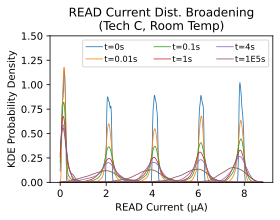

In [6]:
# Select ranges to study
ranges = [0, 8, 16, 24, 31]

# Conductance broadening behavior
fig = plt.figure(figsize=(4, 2.7))
ax = fig.add_subplot(111)
ax.set_title(f"READ Current Dist. Broadening\n(Tech {TECH}, Room Temp)")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for time, color in zip(settings["times"], colors):
    for r in ranges:
        gx = np.linspace(0, settings["gmax"]*1.1e6, 500)
        gvals = data[(data["range"] == r) & (data["timept"] == time)]["g"]
        pdf = scipy.stats.gaussian_kde(gvals*1e6).pdf(gx)
        label = (f"t={time}s" if time < 100 else f"t=1E{int(np.log10(time))}s") if r == 0 else None
        plt.plot(gx*0.2, pdf, color=color, label=label, linewidth=0.8)
ax.legend(ncol=3, handletextpad=0.2, fontsize="small")
ax.set_ylim(*settings["gbroad_ylim"])
ax.set_xlabel("READ Current (µA)")
ax.set_ylabel("KDE Probability Density")
plt.savefig(f"figs/tech{TECH}/broadening-time-i.pdf", bbox_inches="tight")
plt.show()

### Mean Drift and Variance Growth (Time Dependence)
Here, we examine the drift of the distribution mean and variance growth as a function of time.

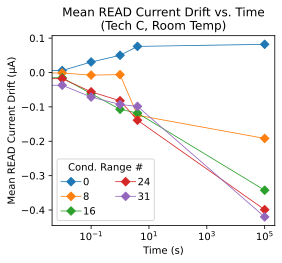

In [7]:
# Mean drift behavior (time dependence)
fig = plt.figure(figsize=(4, 3.5))
ax = fig.add_subplot(111)
ax.set_title(f"Mean READ Current Drift vs. Time\n(Tech {TECH}, Room Temp)")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for r, color in zip(ranges, colors):
    d = data[(data["range"] == r) & (data["gi"] <= settings["gmax"])]
    gi = d.groupby("timept").mean()["gi"]*1e6
    gf = d.groupby("timept").mean()["g"]*1e6
    deltag = gf - gi
    plt.plot(deltag.index, deltag * 0.2, '-D', color=color, label=r, linewidth=0.8)
ax.legend(title="Cond. Range #", ncol=2 if TECH == 'C' else 3, handletextpad=0.2)
if "gmeandrift_t_ylim" in settings:
    ax.set_ylim(*[v*0.2 for v in settings["gmeandrift_t_ylim"]])
ax.set_xscale("log")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Mean READ Current Drift (µA)")
plt.savefig(f"figs/tech{TECH}/mean-drift-vs-time-i.pdf", bbox_inches="tight")
plt.show()

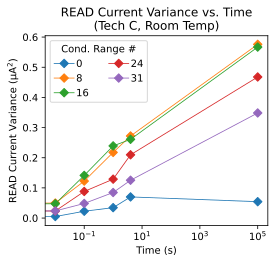

In [8]:
# Variance behavior (time dependence)
fig = plt.figure(figsize=(4, 3.5))
ax = fig.add_subplot(111)
ax.set_title(f"READ Current Variance vs. Time\n(Tech {TECH}, Room Temp)")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for r, color in zip(ranges, colors):
    d = data[(data["range"] == r) & (data["gi"] <= settings["gmax"])]
    gfvar = d.groupby("timept").var()["g"]*(0.2e6**2)
    plt.plot(gfvar.index, gfvar, '-D', color=color, label=r, linewidth=0.8)
ax.legend(title="Cond. Range #", ncol=2, handletextpad=0.2)
if "gvar_t_ylim" in settings:
    ax.set_ylim(*[v*0.2**2 for v in settings["gvar_t_ylim"]])
ax.set_xscale("log")
ax.set_xlabel("Time (s)")
ax.set_ylabel("READ Current Variance (µA$^2$)")
plt.savefig(f"figs/tech{TECH}/var-vs-time-i.pdf", bbox_inches="tight")
plt.show()

### Mean Drift and Variance Growth (Conductance Dependence)
Here, we examine the drift of the distribution mean and variance growth as a function of conductance.

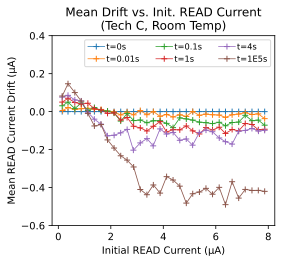

In [9]:
# Mean drift behavior (conductance dependence)
fig = plt.figure(figsize=(4, 3.5))
ax = fig.add_subplot(111)
ax.set_title(f"Mean Drift vs. Init. READ Current\n(Tech {TECH}, Room Temp)")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for time, color in zip(settings["times"], colors):
    d = data[(data["timept"] == time) & (data["gi"] <= settings["gmax"])]
    gi = d.groupby("range").mean()["gi"]*1e6
    gf = d.groupby("range").mean()["g"]*1e6
    deltag = gf - gi
    label = (f"t={time}s" if time < 100 else f"t=1E{int(np.log10(time))}s")
    plt.plot(gi*0.2, deltag*0.2, '-+', color=color, label=label, linewidth=0.8)
ax.legend(ncol=3, handletextpad=0.2, fontsize="small")
ax.set_ylim(*[v*0.2 for v in settings["gmeandrift_gi_ylim"]])
ax.set_xlabel("Initial READ Current (µA)")
ax.set_ylabel("Mean READ Current Drift (µA)")
plt.savefig(f"figs/tech{TECH}/mean-drift-vs-g-i.pdf", bbox_inches="tight")
plt.show()

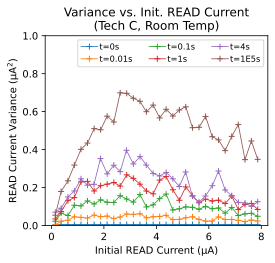

In [10]:
# Variance behavior (conductance dependence)
fig = plt.figure(figsize=(4, 3.5))
ax = fig.add_subplot(111)
ax.set_title(f"Variance vs. Init. READ Current\n(Tech {TECH}, Room Temp)")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for time, color in zip(settings["times"], colors):
    d = data[(data["timept"] == time) & (data["gi"] <= settings["gmax"])]
    gi = d.groupby("range").mean()["gi"]*1e6
    gfvar = (d.groupby("range")).var()["g"]*(1e6**2)
    label = (f"t={time}s" if time < 100 else f"t=1E{int(np.log10(time))}s")
    plt.plot(gi*0.2, gfvar*0.2**2, '-+', color=color, label=label, linewidth=0.8)
ax.legend(ncol=3, handletextpad=0.2, fontsize="small")
ax.set_ylim(*[v*0.2**2 for v in settings["gvar_gi_ylim"]])
ax.set_xlabel("Initial READ Current (µA)")
ax.set_ylabel("READ Current Variance (µA$^2$)")
plt.savefig(f"figs/tech{TECH}/var-vs-g-i.pdf", bbox_inches="tight")
plt.show()

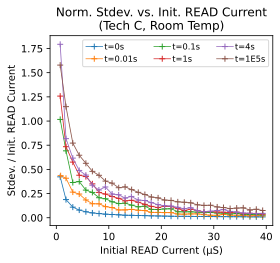

In [11]:
# Norm. stdev. behavior (conductance dependence)
fig = plt.figure(figsize=(4, 3.5))
ax = fig.add_subplot(111)
ax.set_title(f"Norm. Stdev. vs. Init. READ Current\n(Tech {TECH}, Room Temp)")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for time, color in zip(settings["times"], colors):
    d = data[(data["timept"] == time) & (data["gi"] <= settings["gmax"])]
    gi = d.groupby("range").mean()["gi"]*1e6
    gfnormdev = d.groupby("range").std()["g"] / d.groupby("range").mean()["gi"]
    label = (f"t={time}s" if time < 100 else f"t=1E{int(np.log10(time))}s")
    plt.plot(gi, gfnormdev, '-+', color=color, label=label, linewidth=0.8)
ax.legend(ncol=3, handletextpad=0.2, fontsize="small")
ax.set_xlabel("Initial READ Current (µS)")
ax.set_ylabel("Stdev. / Init. READ Current")
plt.savefig(f"figs/tech{TECH}/norm-stdev-vs-g-i.pdf", bbox_inches="tight")
plt.show()

## Temperature dependence analysis via 1hr bake

Here, we analyze the effect of baking on the distribution broadening. In particular, we will examine examples of the conductance distributions broadening for different temperatures and then analyze the temperature-dependent mean drift and variance. We can first load the data and preprocess it a little bit:

In [12]:
# Load data for technology
colnames = ["addr", "time", "r", "g", "temp"]
data = pd.read_csv(f"data/tech{TECH}/bake.tsv.gz", names=colnames, sep='\t')

# Get conductance range
data["gi"] = data.groupby(["addr", "temp"])["g"].transform("first")
data["range"] = np.int32(data["gi"] / settings["gmax"] * 32)

# Filter out the rest of the data
data = data[data["time"] > 100].groupby(["addr", "temp"]).first().reset_index()

# Show data
data.head()

,addr,temp,time,r,g,gi,range
0,0,100,11755.538581,17964.912281,0.000056,0.000039,30
1,0,140,8588.506214,16020.025031,0.000062,0.000058,46
2,0,180,26493.001072,19711.260828,0.000051,0.000039,30
3,0,220,17142.441053,23744.927536,0.000042,0.000046,36
4,0,260,61807.724560,23968.634794,0.000042,0.000047,37


### Conductance distribution broadening behavior

Below are examples of conductance broadening behavior at different temperatures:

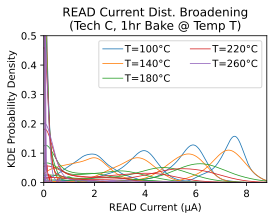

In [13]:
# Select ranges to study
ranges = [0, 8, 16, 24, 31]

# Conductance broadening behavior
fig = plt.figure(figsize=(4, 2.7))
ax = fig.add_subplot(111)
ax.set_title(f"READ Current Dist. Broadening\n(Tech {TECH}, 1hr Bake @ Temp T)")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for temp, color in zip(settings["temps"], colors):
    for r in ranges:
        gx = np.linspace(0, settings["gmax"]*1.1e6, 500)
        gvals = data[(data["range"] == r) & (data["temp"] == temp)]["g"]
        pdf = scipy.stats.gaussian_kde(gvals*1e6).pdf(gx)
        plt.plot(gx*0.2, pdf, color=color, label=f"T={temp}°C" if r==0 else None, linewidth=0.8)
ax.legend(ncol=2, handletextpad=0.2)
ax.set_xlim(0, settings["gmax"]*1.1e6*0.2)
ax.set_ylim(*settings["gbroad_temp_ylim"])
ax.set_xlabel("READ Current (µA)")
ax.set_ylabel("KDE Probability Density")
plt.savefig(f"figs/tech{TECH}/broadening-temp-i.pdf", bbox_inches="tight")
plt.show()

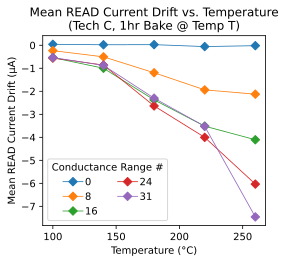

In [14]:
# Mean drift behavior (temperature dependence)
fig = plt.figure(figsize=(4, 3.5))
ax = fig.add_subplot(111)
ax.set_title(f"Mean READ Current Drift vs. Temperature\n(Tech {TECH}, 1hr Bake @ Temp T)")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for r, color in zip(ranges, colors):
    d = data[data["range"] == r]
    gi = d.groupby("temp").mean()["gi"]*1e6
    gf = d.groupby("temp").mean()["g"]*1e6
    deltag = gf - gi
    plt.plot(deltag.index, deltag * 0.2, '-D', color=color, label=r, linewidth=0.8)
ax.legend(title="Conductance Range #", ncol=2 if TECH == 'C' else 3, handletextpad=0.2)
if "gmeandrift_temp_ylim" in settings:
    ax.set_ylim(*[v*0.2 for v in settings["gmeandrift_temp_ylim"]])
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Mean READ Current Drift (µA)")
plt.savefig(f"figs/tech{TECH}/mean-drift-vs-temp-i.pdf", bbox_inches="tight")
plt.show()

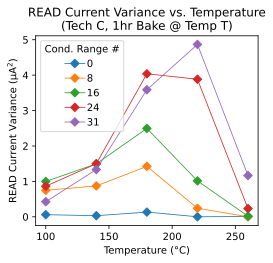

In [15]:
# Variance behavior (temperature dependence)
fig = plt.figure(figsize=(4, 3.5))
ax = fig.add_subplot(111)
ax.set_title(f"READ Current Variance vs. Temperature\n(Tech {TECH}, 1hr Bake @ Temp T)")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for r, color in zip(ranges, colors):
    d = data[data["range"] == r]
    gfvar = d.groupby("temp").var()["g"]*(1e6**2)
    plt.plot(gfvar.index, gfvar*0.2**2, '-D', color=color, label=r, linewidth=0.8)
ax.legend(title="Cond. Range #", ncol=1, handletextpad=0.2)
if "gvar_temp_ylim" in settings:
    ax.set_ylim(*[v*0.2**2 for v in settings["gvar_temp_ylim"]])
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("READ Current Variance (µA$^2$)")
plt.savefig(f"figs/tech{TECH}/var-vs-temp-i.pdf", bbox_inches="tight")
plt.show()